# Sample Tree Locations

This notebook generates a random sample of point locations across the Sierras and extracts a series of raster values at each location. We'll use this data to understand the distributions of height values and the proportional area of each vegetation type across the ecoregion.

In [1]:
# packages
import os
import numpy as np
import geopandas as gpd
import elapid as ela
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [2]:
# paths
base = '/home/cba/src/cfo-big-trees'
data = os.path.join(base, 'data')
vector = os.path.join(data, 'vector')
raster = os.path.join(data, 'raster')
plots = os.path.join(base, 'docs', 'img')

sierra_poly = os.path.join(vector, 'sierra-ecoregion.gpkg')
height_raster = os.path.join(raster, 'SierraEcoregion-Vegetation-CanopyHeight-2020-Summer-00010m.tif')
class_raster = os.path.join(raster, 'SierraEcoregion-Vegetation-Classes-2020-Summer-00030m.tif')
class_labels = os.path.join(raster, 'us_140esp_accel_reclass_wRAT.tif.vat.dbf')
output_samples = os.path.join(vector, 'point-samples-all.gpkg')

In [3]:
# create a random geographic sample across the full ecoregion extent
n_samples = 200_000
sample_pts = ela.sample_vector(sierra_poly, count=n_samples)

In [4]:
# extract values from each raster dataset
annotated = ela.annotate(sample_pts, [height_raster, class_raster], labels=['height', 'vegtype'], drop_na=True)

Raster:   0%|                    | 0/2 [00:00<?, ?it/s]

In [5]:
# filter improperly masked datasets (values with 255 are nodata in the veg type raster)
valid = annotated['vegtype'] != 255
annotated = annotated[valid].reset_index(drop=True)

# save the data to disk for later use
annotated.to_file(output_samples, driver='GPKG')

In [6]:
# construct a set of labels for each class to plot
unique_classes = list(annotated['vegtype'].unique())
unique_classes.sort()

class_labels_df = gpd.read_file(class_labels)
labels = {}
for _, row in class_labels_df.iterrows():
    cls = int(row['VALUE'])
    if cls in unique_classes:
        vegclass = row['vegclass']
        if vegclass not in ['shrub', 'grass']:
            labels[cls] = row['vegclass']

print(labels)

{5: 'riparian', 7: 'low_elev_woodland', 8: 'hi_elev_woodland', 9: 'pipo_jeff', 11: 'mid_elev_conifer', 12: 'high_elev_conifer'}


In [7]:
# print summary stats on the tree data for each class
heights = []
for vegtype, veglabel in labels.items():
    idxs = annotated['vegtype'] == vegtype
    sub = annotated[idxs].reset_index(drop=True)
    trees_idx = sub['height'] >= 5
    trees = sub[trees_idx]['height']
    pct_trees = 100 * (trees_idx.sum() / len(sub))
    pct95 = np.percentile(trees, 95)
    pct50 = np.percentile(trees, 50)
    heights.append(trees)
    print(f"{veglabel:18s} | {pct_trees:0.2f} (% trees) | {pct50:0.2f} (median) | {pct95:0.2f} (95th)")

riparian           | 81.23 (% trees) | 15.00 (median) | 32.00 (95th)
low_elev_woodland  | 53.41 (% trees) | 10.00 (median) | 24.00 (95th)
hi_elev_woodland   | 22.45 (% trees) | 7.00 (median) | 15.00 (95th)
pipo_jeff          | 50.28 (% trees) | 10.00 (median) | 20.00 (95th)
mid_elev_conifer   | 81.66 (% trees) | 16.00 (median) | 32.00 (95th)
high_elev_conifer  | 68.50 (% trees) | 12.00 (median) | 24.00 (95th)


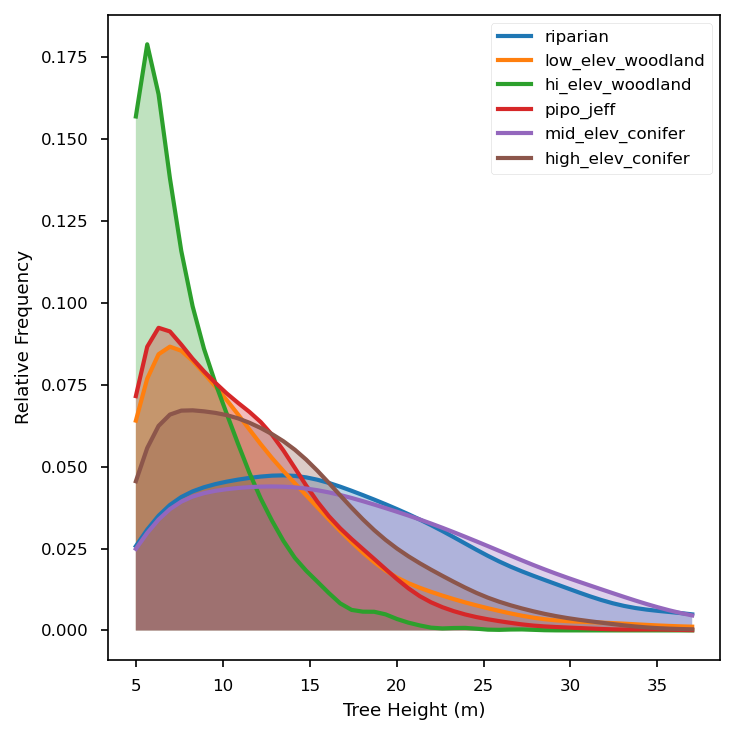

In [10]:
mpl.style.use('seaborn-paper')
label = [val for key, val in labels.items()]
plt.figure(figsize=(5,5), dpi=150)
plt = density_dist(heights, plot=plt, label=label, xlabel='Tree Height (m)')
plt.savefig(os.path.join(plots, 'height-by-vegclass.png'), dpi=200)

In [8]:
# plot frequency distributions for each veg type
def density_dist(
    ydata,
    plot=None,
    fill=True,
    fill_alpha=0.3,
    label=None,
    linewidth=2,
    xlabel=None,
    ylabel="Relative Frequency",
    xlim=None,
    ylim=None,
    covar=0.25,
    cutoff=2,
    **kwargs,
):
    # we want ydata to come as a list form to handle uneven sample sizes
    if type(ydata) is list:
        ncol = len(ydata)

    # set up a function to handle numpy arrays
    elif type(ydata) is np.ndarray:

        # if the ndarray is only 1-d, convert it to a list
        if ydata.ndim == 1:
            ydata = [ydata]

        # otherwise, loop through each column and assign as unique items in list
        else:
            newdata = []
            for i in range(ydata.shape[1]):
                newdata.append(ydata[:, i])
            ydata = newdata
        ncol = len(ydata)
    else:
        print("[ ERROR ]: unsupported ydata format. must be a list or np.ndarray")

    # if a plot object isn't provided, create one
    if not plot:
        plot = plt

    # handle labels similar to color, but don't assign defaults
    if label is not None:
        if type(label) is str:
            label = list(label)
        else:
            if len(label) < ncol:
                print("[ ERROR ]: number of labels specified doesn't match number of columns")
                label = []
                for i in range(ncol):
                    label.append(None)
    else:
        label = []
        for i in range(ncol):
            label.append(None)

    # if xlim isn't set, find the min/max range for plot based on %cutoff
    if not xlim:
        xmin = []
        xmax = []
        for i in range(ncol):
            xmin.append(np.percentile(np.array(ydata[i]), cutoff))
            xmax.append(np.percentile(np.array(ydata[i]), 100 - cutoff))
        xlim = [min(xmin), max(xmax)]

    # set the x plot size
    xs = np.linspace(xlim[0], xlim[1])

    # loop through each feature, calculate the covariance, and plot
    for i in range(ncol):
        dns = gaussian_kde(np.array(ydata[i]))
        dns.covariance_factor = lambda: covar
        dns._compute_covariance()
        ys = dns(xs)

        # plotting functions
        plot.plot(xs, ys, label=label[i], linewidth=linewidth, **kwargs)
        if fill:
            plot.fill_between(xs, ys, alpha=fill_alpha)

    # finalize other meta plot routines
    plot.xlabel(xlabel)
    plot.ylabel(ylabel)
    if label[0] is not None:
        plot.legend()
    plot.tight_layout()

    # return the final plot object for further manipulation
    return plot